In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../datasets/students_simple.csv')

In [3]:
col_name1 = df.columns[3]
col_name2 = df.columns[9]

In [4]:
df = df.dropna(subset=[col_name1, col_name2])

In [5]:
x = df[col_name1].values
y = df[col_name2].values

In [6]:
n = len(x)

In [7]:
mean_x = np.mean(x)
mean_y = np.mean(y)
sign_x = np.sign(x - mean_x)
sign_y = np.sign(y - mean_y)
fechner = np.mean(sign_x * sign_y)
fechner

np.float64(-0.7)

In [8]:
xm = x - np.mean(x)
ym = y - np.mean(y)
pearson_r = np.dot(xm, ym) / (np.sqrt(np.dot(xm, xm) * np.dot(ym, ym)) + 1e-10)
pearson_r

np.float64(-0.6818137442427294)

In [9]:
z = np.arctanh(pearson_r)
se = 1 / np.sqrt(n - 3)
z_alpha = 1.96
ci_low_z = z - z_alpha * se
ci_high_z = z + z_alpha * se
ci_low = np.tanh(ci_low_z)
ci_high = np.tanh(ci_high_z)
ci_low, ci_high

(np.float64(-0.8637343054217188), np.float64(-0.3426798212890245))

In [10]:
rank_x = pd.Series(x).rank()
rank_y = pd.Series(y).rank()

In [11]:
rxm = rank_x - np.mean(rank_x)
rym = rank_y - np.mean(rank_y)
spearman_r = np.dot(rxm, rym) / (np.sqrt(np.dot(rxm, rxm) * np.dot(rym, rym)) + 1e-10)
spearman_r

np.float64(-0.682348561688204)

In [12]:
from collections import Counter

In [13]:
concordant = 0
discordant = 0
for i in range(n):
    for j in range(i + 1, n):
        if (x[i] < x[j] and y[i] < y[j]) or (x[i] > x[j] and y[i] > y[j]):
            concordant += 1
        elif (x[i] < x[j] and y[i] > y[j]) or (x[i] > x[j] and y[i] < y[j]):
            discordant += 1

In [14]:
def count_ties(arr):
    counts = Counter(arr)
    ties = sum(t * (t - 1) / 2 for t in counts.values() if t > 1)
    return ties

In [15]:
ties_x = count_ties(x)
ties_y = count_ties(y)

In [16]:
total_pairs = n * (n - 1) / 2
denom = np.sqrt((total_pairs - ties_x) * (total_pairs - ties_y)) + 1e-10
kendall_tau = (concordant - discordant) / denom
kendall_tau

np.float64(-0.5039805528124567)

In [17]:
import matplotlib.pyplot as plt

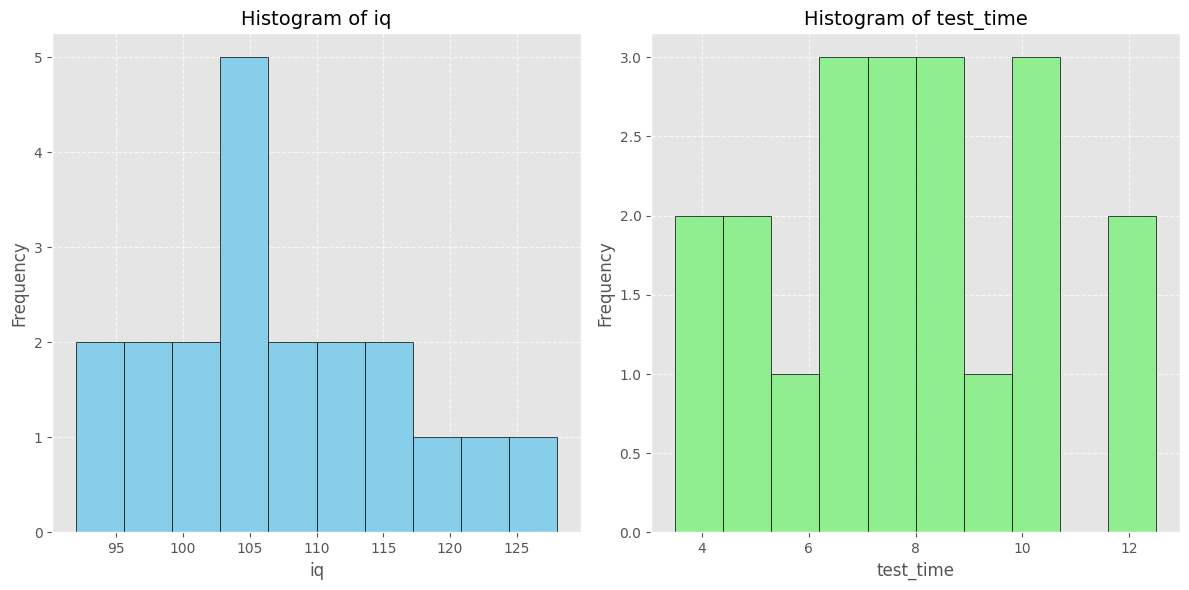

In [18]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(x, bins=10, color='skyblue', edgecolor='black')
axs[0].set_title(f'Histogram of {col_name1}', fontsize=14)
axs[0].set_xlabel(col_name1, fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.7)

axs[1].hist(y, bins=10, color='lightgreen', edgecolor='black')
axs[1].set_title(f'Histogram of {col_name2}', fontsize=14)
axs[1].set_xlabel(col_name2, fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

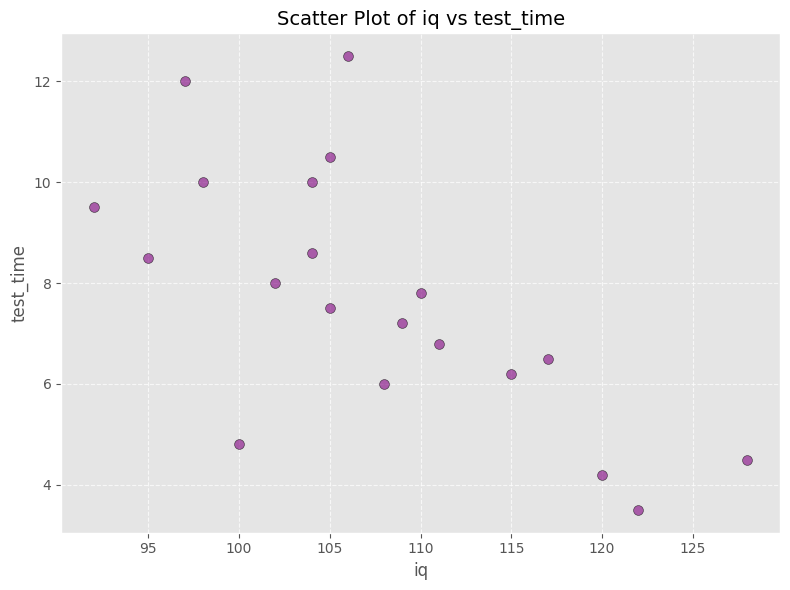

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='purple', alpha=0.6, edgecolor='black', s=50)
plt.title(f'Scatter Plot of {col_name1} vs {col_name2}', fontsize=14)
plt.xlabel(col_name1, fontsize=12)
plt.ylabel(col_name2, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
def least_squares_fit(X, y):
    X = np.array(X)
    XT = X.T
    XTX = np.dot(XT, X)
    XTX_inv = np.linalg.inv(XTX + 1e-10 * np.eye(XTX.shape[0]))
    XTy = np.dot(XT, y)
    w = np.dot(XTX_inv, XTy)
    return w

In [21]:
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]

In [22]:
X_lin = np.vstack([np.ones(n), x]).T
w_lin = least_squares_fit(X_lin, y)
w0_lin, w1_lin = w_lin
print(f'Linear: y = {w1_lin:.4f} * x + {w0_lin:.4f}')

Linear: y = -0.1831 * x + 27.3961


In [23]:
y_pred_lin = w1_lin * x_sorted + w0_lin

In [24]:
X_quad = np.vstack([np.ones(n), x, x**2]).T
w_quad = least_squares_fit(X_quad, y)
w0_quad, w1_quad, w2_quad = w_quad
print(f'Quadratic: y = {w2_quad:.4f} * x^2 + {w1_quad:.4f} * x + {w0_quad:.4f}')

Quadratic: y = -0.0033 * x^2 + 0.5396 * x + -11.8827


In [25]:
y_pred_quad = w2_quad * x_sorted**2 + w1_quad * x_sorted + w0_quad

In [26]:
X_hyp = np.vstack([np.ones(n), 1 / x]).T
w_hyp = least_squares_fit(X_hyp, y)
w0_hyp, w1_hyp = w_hyp
print(f'Hyperbolic: y = {w1_hyp:.4f} / x + {w0_hyp:.4f}')

Hyperbolic: y = 2091.8569 / x + -11.8858


In [27]:
y_pred_hyp = w1_hyp / x_sorted + w0_hyp

In [28]:
log_y = np.log(y)
X_exp = np.vstack([np.ones(n), x]).T
w_exp_lin = least_squares_fit(X_exp, log_y)
w0_exp = np.exp(w_exp_lin[0])
w1_exp = np.exp(w_exp_lin[1])
print(f'Exponential: y = {w0_exp:.4f} * {w1_exp:.4f}^x')

Exponential: y = 130.8014 * 0.9735^x


In [29]:
y_pred_exp = w0_exp * (w1_exp ** x_sorted)

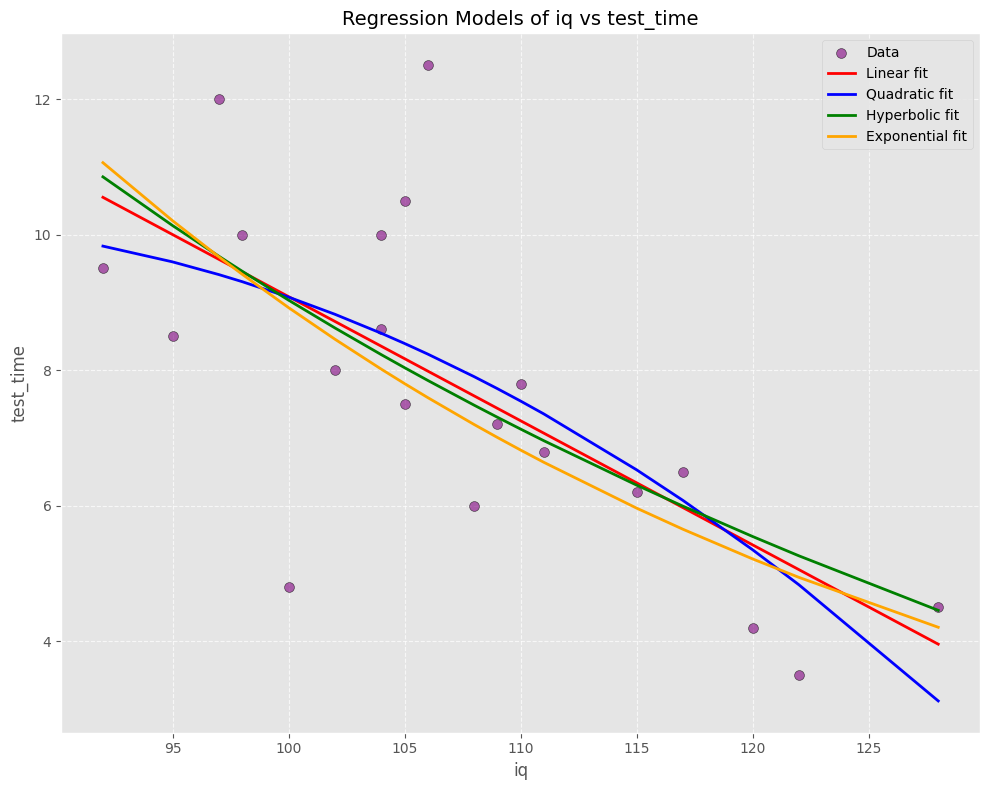

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='purple', alpha=0.6, edgecolor='black', s=50, label='Data')
plt.plot(x_sorted, y_pred_lin, color='red', linewidth=2, label='Linear fit')
plt.plot(x_sorted, y_pred_quad, color='blue', linewidth=2, label='Quadratic fit')
plt.plot(x_sorted, y_pred_hyp, color='green', linewidth=2, label='Hyperbolic fit')
plt.plot(x_sorted, y_pred_exp, color='orange', linewidth=2, label='Exponential fit')
plt.title(f'Regression Models of {col_name1} vs {col_name2}', fontsize=14)
plt.xlabel(col_name1, fontsize=12)
plt.ylabel(col_name2, fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
from scipy.stats import f

def fisher_test(y_pred, df_reg):
    df_err = n - df_reg - 1
    SSE = np.sum((y - y_pred)**2)
    SSR = np.sum((y_pred - mean_y)**2)
    if df_err <= 0:
        return None, None
    MS_reg = SSR / df_reg
    MS_err = SSE / df_err if df_err > 0 else 0
    F = MS_reg / (MS_err + 1e-10)
    alpha = 0.05
    f_crit = f.ppf(1 - alpha, df_reg, df_err)
    return F, f_crit
    

In [32]:
F_best, f_crit_best = fisher_test(X_quad @ w_quad, 2)
print(f'For best model (Quadratic):')
print(f'F-statistic: {F_best:.4f}')
print(f'Critical F (alpha=0.05): {f_crit_best:.4f}')

For best model (Quadratic):
F-statistic: 7.9258
Critical F (alpha=0.05): 3.5915


In [33]:
F_worst, f_crit_worst = fisher_test(w0_exp * (w1_exp ** x), 1)
print(f'For worst model (Exponential):')
print(f'F-statistic: {F_worst:.4f}')
print(f'Critical F (alpha=0.05): {f_crit_worst:.4f}')

For worst model (Exponential):
F-statistic: 16.0237
Critical F (alpha=0.05): 4.4139


1. **Корреляции**: Все рассчитанные корреляции (Фехнера, Пирсона, Спирмена и Кендалла) последовательно указывают на умеренную отрицательную связь между IQ и временем прохождения теста, предполагая, что более высокий IQ ассоциируется с более коротким временем. Сходство между различными мерами говорит об устойчивости результатов к ненормальности распределений или наличию связей в данных.

2. **Визуализация**: Гистограммы показывают ненормальные распределения: IQ скошено в сторону высоких значений, а время теста имеет несколько бимодальный характер. Диаграмма рассеяния визуально подтверждает отрицательную зависимость и выделяет потенциальные нелинейные паттерны, что оправдывает использование кривых моделей регрессии.

3. **Уравнения регрессии**: Линейная и квадратичная модели лучше всего описывают наблюдаемую кривую зависимость, в то время как гиперболическая менее точна. Экспоненциальная модель также хорошо соответствует данным, но может не обобщаться на крайние значения. График демонстрирует, как квадратичная модель учитывает уменьшение времени теста по мере роста IQ с эффектом насыщения.

4. **Проверка уравнений регрессии**: Оба проверенных уравнения (квадратичное как лучшее и экспоненциальное как худшее) статистически значимы по критерию Фишера, поскольку F-статистика превышает критическое значение. Однако квадратичная модель предпочтительна благодаря лучшему балансу между подгонкой и сложностью, в то время как экспоненциальная хуже соответствует с данными на крайностях, несмотря на более высокое F.

5. **Общий вывод**: Анализ подтверждает наличие четкой обратной зависимости между IQ и временем теста, лучше всего моделируемой квадратичной регрессией.